In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset_constant_padding_final.zip to dataset_constant_padding_final.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_constant_padding_final.zip']), 'r')
data.extractall()

In [3]:
import os

In [4]:
train_path = '/content/dataset_constant_padding_final/train'
test_path = '/content/dataset_constant_padding_final/test'
val_path = '/content/dataset_constant_padding_final/validation'



---
Common functions


In [5]:
classes = ['Benign', 'Malignant']

In [6]:
from matplotlib import pyplot
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])

In [7]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

x_test, y_test, labels = load_data('/content/dataset_constant_padding_final/test/')
print(labels)

100%|██████████| 2/2 [00:00<00:00, 32.06it/s]

40 images loaded from /content/dataset_constant_padding_final/test/ directory.
{0: 'Benign', 1: 'Malignant'}


In [8]:
from sklearn.metrics import classification_report
def validateResults(model):   
  predictions = model.predict(x_test, batch_size=32)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_test, axis=0)

  print("\n"+ classification_report(y_test, y_pred, target_names=classes))
  print(confusion_matrix(y_test, y_pred))
  confusion_mtx = confusion_matrix(y_test, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)



---

VGG models


In [9]:
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [10]:
# define cnn model
def BuildVGG16():
  # load model
  model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  
  last_layer = model.get_layer('block5_pool')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(2, activation='sigmoid')(x) #2 clases de salida  
  model = tf.keras.Model(model.input, x)    

  return model

In [11]:
modelVGG16 = BuildVGG16()
modelVGG16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
EPOCHS = 100
batch_size=32
es = EarlyStopping(monitor='val_loss', patience=20, verbose=1, min_delta=1e-4)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)

In [13]:
datagen = ImageDataGenerator(rescale=1./255, rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)

train_it = datagen.flow_from_directory(train_path, batch_size=batch_size, target_size=(224, 224))
validation_it = datagen.flow_from_directory(val_path, batch_size=batch_size, target_size=(224, 224))
test_it = datagen.flow_from_directory(test_path, batch_size=batch_size, target_size=(224, 224))

Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [14]:
def fitVGG16v1():
  modelv1 = BuildVGG16()
  modelv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # fit model
  historyVGG16_v1 = modelv1.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=EPOCHS, 
      verbose=1,
      callbacks=[rlrop, es])
  
  return historyVGG16_v1, modelv1

In [15]:
historyVGG16_v1, modelv1 = fitVGG16v1()

Epoch 1/100
4/4 [==============================] - 17s 2s/step - loss: 0.8142 - accuracy: 0.6224 - val_loss: 0.8318 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 2s 412ms/step - loss: 0.6534 - accuracy: 0.6837 - val_loss: 0.5224 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 2s 408ms/step - loss: 0.6203 - accuracy: 0.7245 - val_loss: 0.5649 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 2s 533ms/step - loss: 0.4636 - accuracy: 0.7755 - val_loss: 0.3601 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 2s 529ms/step - loss: 0.4705 - accuracy: 0.8163 - val_loss: 0.5559 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 2s 388ms/step - loss: 0.4361 - accuracy: 0.7857 - val_loss: 0.4159 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 2s 391ms/step - loss: 0.421

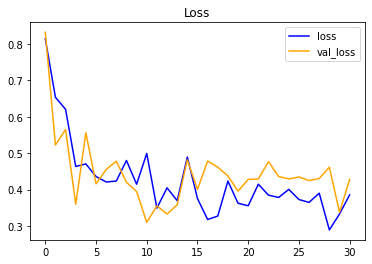

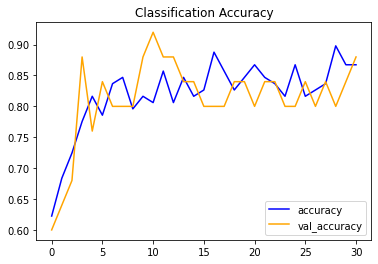

In [16]:
summarize_diagnostics(historyVGG16_v1)


              precision    recall  f1-score   support

      Benign       0.74      0.54      0.62        26
   Malignant       0.43      0.64      0.51        14

    accuracy                           0.57        40
   macro avg       0.58      0.59      0.57        40
weighted avg       0.63      0.57      0.58        40

[[14 12]
 [ 5  9]]


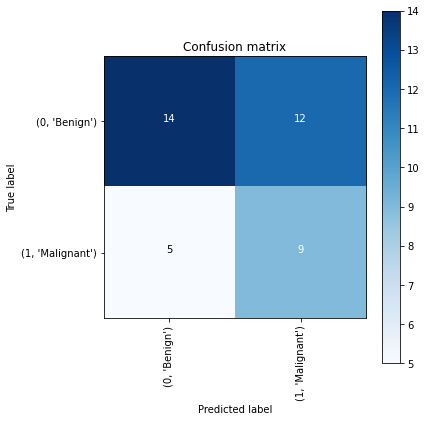

In [17]:
validateResults(modelv1)

VGG16 v2

In [18]:
def fitVGG16v2():
  datagen2 = ImageDataGenerator(rescale=1./255)
  
  train_it_v2 = datagen2.flow_from_directory(train_path, batch_size=batch_size, target_size=(224, 224))
  validation_it_v2 = datagen2.flow_from_directory(val_path, batch_size=batch_size, target_size=(224, 224))
  test_it_v2 = datagen2.flow_from_directory(test_path, batch_size=batch_size, target_size=(224, 224))

  modelv2 = BuildVGG16()
  modelv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # fit model
  historyVGG16_v2 = modelv2.fit(
      train_it_v2, 
      steps_per_epoch=len(train_it_v2),
      validation_data=validation_it_v2, 
      validation_steps=len(validation_it_v2), 
      epochs=EPOCHS, 
      verbose=1)
  
  return historyVGG16_v2, modelv2

In [19]:
historyVGG16_v2, modelv2 = fitVGG16v2()

Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/100
4/4 [==============================] - 2s 242ms/step - loss: 0.7665 - accuracy: 0.6531 - val_loss: 0.5761 - val_accuracy: 0.6400
Epoch 2/100
4/4 [==============================] - 1s 162ms/step - loss: 0.6039 - accuracy: 0.6837 - val_loss: 0.4290 - val_accuracy: 0.8000
Epoch 3/100
4/4 [==============================] - 1s 165ms/step - loss: 0.5404 - accuracy: 0.7347 - val_loss: 0.5367 - val_accuracy: 0.6800
Epoch 4/100
4/4 [==============================] - 1s 163ms/step - loss: 0.5894 - accuracy: 0.7143 - val_loss: 0.3799 - val_accuracy: 0.8800
Epoch 5/100
4/4 [==============================] - 1s 214ms/step - loss: 0.5481 - accuracy: 0.7551 - val_loss: 0.4037 - val_accuracy: 0.8000
Epoch 6/100
4/4 [==============================] - 1s 177ms/step - loss: 0.4081 - accuracy: 0.8163 - val_loss: 0.6457 - val_accuracy: 0.6400
Epoch 7/100
4/4 [=================

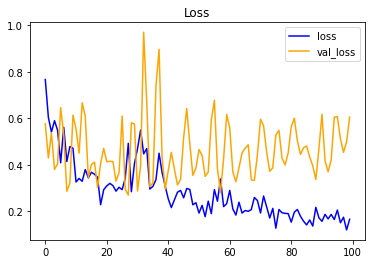

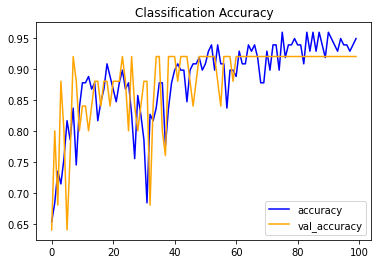

In [20]:
summarize_diagnostics(historyVGG16_v2)


              precision    recall  f1-score   support

      Benign       0.70      0.81      0.75        26
   Malignant       0.50      0.36      0.42        14

    accuracy                           0.65        40
   macro avg       0.60      0.58      0.58        40
weighted avg       0.63      0.65      0.63        40

[[21  5]
 [ 9  5]]


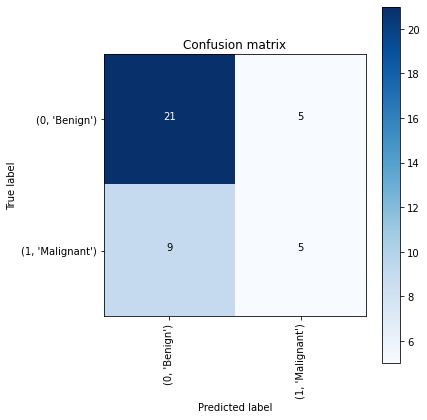

In [21]:
validateResults(modelv2)

VGG16 v3

In [26]:
from tensorflow.keras.optimizers import RMSprop
def fitVGG16v3():
  modelv3 = BuildVGG16()
  opt = tf.keras.optimizers.SGD(learning_rate=0.01)  
  modelv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


  # fit model
  historyVGG16_v3 = modelv3.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=EPOCHS, 
      verbose=1)
  
  return historyVGG16_v3, modelv3

In [27]:
historyVGG16_v3, modelv3 = fitVGG16v3()

Epoch 1/100
4/4 [==============================] - 3s 683ms/step - loss: 0.9836 - accuracy: 0.6633 - val_loss: 0.5998 - val_accuracy: 0.6000
Epoch 2/100
4/4 [==============================] - 2s 414ms/step - loss: 0.7620 - accuracy: 0.6327 - val_loss: 0.5490 - val_accuracy: 0.9200
Epoch 3/100
4/4 [==============================] - 2s 543ms/step - loss: 0.7973 - accuracy: 0.6531 - val_loss: 0.7061 - val_accuracy: 0.6000
Epoch 4/100
4/4 [==============================] - 2s 412ms/step - loss: 0.6591 - accuracy: 0.6429 - val_loss: 0.5811 - val_accuracy: 0.6400
Epoch 5/100
4/4 [==============================] - 2s 418ms/step - loss: 0.7623 - accuracy: 0.7041 - val_loss: 0.5607 - val_accuracy: 0.6400
Epoch 6/100
4/4 [==============================] - 2s 416ms/step - loss: 0.6090 - accuracy: 0.7143 - val_loss: 0.5418 - val_accuracy: 0.7200
Epoch 7/100
4/4 [==============================] - 2s 421ms/step - loss: 0.4792 - accuracy: 0.7449 - val_loss: 0.6356 - val_accuracy: 0.6000
Epoch 8/100
4

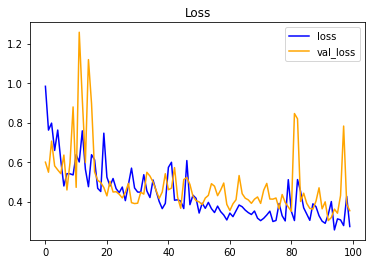

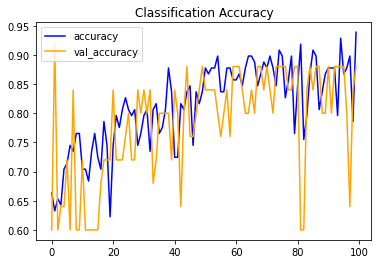

In [28]:
summarize_diagnostics(historyVGG16_v3)


              precision    recall  f1-score   support

      Benign       0.76      0.62      0.68        26
   Malignant       0.47      0.64      0.55        14

    accuracy                           0.62        40
   macro avg       0.62      0.63      0.61        40
weighted avg       0.66      0.62      0.63        40

[[16 10]
 [ 5  9]]


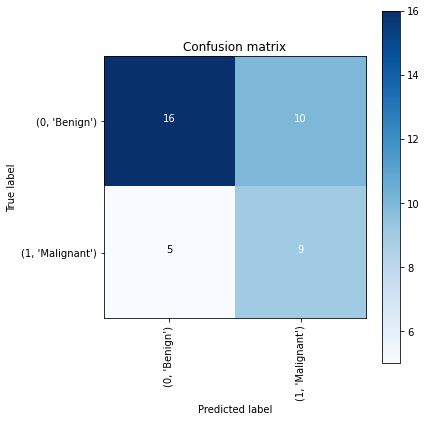

In [29]:
validateResults(modelv3)